# Building

In [97]:
import pandas as pd
import numpy as np
import pathlib
import sys
from cobra.io import read_sbml_model

#sys.path.append(r"C:/Users/Utilizador/OneDrive - Universidade do Minho/IPK/Code/Models")
#sys.path.append(r"/home/tiagomachado/OneDrive/IPK/Code/Models/")

from model_functions import *
from cobra.flux_analysis import flux_variability_analysis
from cobra import flux_analysis, Reaction

#General Core Model
general_model = read_sbml_model('PlantCoreMetabolism_v2_0_0_deprotonated.sbml')

In [98]:
"""
Arabidopsis biomass
"""

reaction = Reaction('Arabidopsis_biomass_tx')
reaction.name = 'Arabidopsis biomass'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default

#Import the pandas dataframe
df = pd.read_csv("Final_Biomass_V1.csv")

#Get a list with the metabolite IDs from the generic model
met_list = []

for id in df.loc[:, "Ids"]:
    met = general_model.metabolites.get_by_id(id)
    met_list.append(met)

#Create a list with the coefficients
coef = list(df.loc[:, "Arabidopsis"])

#Add metabolites to the model: dictionary - keys are metabolites and values are the coefficients
for i in range(len(coef)):
    reaction.add_metabolites({met_list[i]: coef[i]})

#Add reaction to the model
general_model.add_reactions([reaction])

In [99]:
"""
Maize Biomass
"""
#Create the biomass reaction
reaction = Reaction('Maize_biomass_tx')
reaction.name = 'Maize biomass'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.

#Import the pandas dataframe
df = pd.read_csv("Final_Biomass_V1.csv")

#Get a list with the metabolite IDs from the generic model
met_list = []

for id in df.loc[:,"Ids"]:
    met = general_model.metabolites.get_by_id(id)
    met_list.append(met)

#Create a list with the coefficients
coef = list(df.loc[:,"Maize"])

#Add metabolites to the model: dictionary - keys are metabolites and values are the coefficients
for i in range(len(coef)):
    reaction.add_metabolites({met_list[i]:coef[i]})

general_model.add_reactions([reaction])

In [100]:
"""
Malate/Pyruvate Transporter
"""

MAL_c = general_model.metabolites.MAL_c
MAL_p = general_model.metabolites.MAL_p
PYRUVATE_c = general_model.metabolites.PYRUVATE_c
PYRUVATE_p = general_model.metabolites.PYRUVATE_p

#Create the biomass reaction
transporter = Reaction('PYR_MAL_pc')
transporter.name = 'Malate/Pyruvate Transport'
transporter.lower_bound = -1000.  # This is the default
transporter.upper_bound = 1000.

transporter.add_metabolites({
    PYRUVATE_p: -1.0,
    MAL_c: -1.0,
    PYRUVATE_c: 1.0,
    MAL_p: 1.0
})

general_model.add_reactions([transporter])

In [101]:
"""
Proton mediated pyruvate transporter
"""

Pyr_c = general_model.metabolites.PYRUVATE_c
H_c = general_model.metabolites.PROTON_c
Pyr_p = general_model.metabolites.PYRUVATE_p
H_p = general_model.metabolites.PROTON_p

#Create the biomass reaction
transporter = Reaction('Pyr_H_pc')
transporter.name = 'Proton Mediated Pyruvate Transport'
transporter.lower_bound = -1000.  # This is the default
transporter.upper_bound = 1000.

transporter.add_metabolites({
    Pyr_c: -1.0,
    H_c: -1.0,
    Pyr_p: 1.0,
    H_p: 1.0
})

general_model.add_reactions([transporter])

In [102]:
"""
Correct proton stoichiometry of PEP transporter
"""

H_c = general_model.metabolites.PROTON_c
H_p = general_model.metabolites.PROTON_p
PI_c = general_model.metabolites.Pi_c
PI_p = general_model.metabolites.Pi_p
PEP_c = general_model.metabolites.PHOSPHO_ENOL_PYRUVATE_c
PEP_p = general_model.metabolites.PHOSPHO_ENOL_PYRUVATE_p

#Create the biomass reaction
transporter = Reaction('PPT_pc')
transporter.name = 'Phosphoenolpyruvate Transporter'
transporter.lower_bound = -1000.  # This is the default
transporter.upper_bound = 1000.

transporter.add_metabolites({
    PEP_p: -1.0,
    H_p: -1.0,
    PI_c: -1.0,
    PEP_c: 1.0,
    H_c: 1.3,
    PI_p: 1.0
})

general_model.add_reactions([transporter])

In [103]:
"""
Asp/OAA transporter
"""

# OAA_c = general_model.metabolites.OXALACETIC_ACID_c
# OAA_p = general_model.metabolites.OXALACETIC_ACID_p
# ASP_c = general_model.metabolites.L_ASPARTATE_c
# ASP_p = general_model.metabolites.L_ASPARTATE_p
#
# #Create the biomass reaction
# transporter = Reaction('ASP_OAA_pc')
# transporter.name = 'Aspartate/Oxaloacetate Transport'
# transporter.lower_bound = -1000.  # This is the default
# transporter.upper_bound = 1000.
#
# transporter.add_metabolites({
#     ASP_p: -1.0,
#     OAA_c: -1.0,
#     ASP_c: 1.0,
#     OAA_p: 1.0
# })
#
# general_model.add_reactions([transporter])

'\nAsp/OAA transporter\n'

In [104]:
"""
Adding BHAC
"""
import cobramod as cm
from pathlib import Path
path = Path.cwd().resolve().joinpath("bhac_data")

# new metabolites:
# Beta-Hydroxyaspartate
cm.add_metabolites(
    model=general_model,
    obj='BETA_HYDROXYASPARTATE_x, BETA_HYDROXYASPARTATE_x, x, C4H6N1O5, -1',
    directory=path
)

# Iminosuccinat (= Iminoaspartate) needed for reaction 3)
cm.add_metabolites(
    model=general_model,
    obj='IMINOASPARTATE_x, IMINOASPARTATE_x, x, C4H4N1O4, -1',
    directory=path
)

# new reactions:
# 1) Glycine + Oxaloacetate <--> Glyoxylate + L-Aspartate
cm.add_reactions(
    model=general_model,
    obj='AGAT_x, Glycine:oxaloacetate aminotransferase | 1 GLYOX_x + 1 L_ASPARTATE_x <-> 1 GLY_x + 1 OXALACETIC_ACID_x',
    directory=path
)

# 2) beta-Hydroxyaspartate <--> Glycine + Glyoxylate
cm.add_reactions(
    model=general_model,
    obj='BHAA_x, threo-3-hydroxy-D-aspartate glyoxylate-lyase | 1 GLY_x + 1 GLYOX_x <-> 1 BETA_HYDROXYASPARTATE_x',
    directory=path
)

# 3) beta-Hydroxyaspartate --> Immunosuccinat + H2O
cm.add_reactions(
    model=general_model,
    obj='BHAD_x, beta-hydroxyaspartate dehydratase | 1 BETA_HYDROXYASPARTATE_x <-> 1 WATER_x + 1 IMINOASPARTATE_x',
    directory=path
)

# 4) Immunosuccinate + NADH + H+ <--> L-Aspartate + NAD+
cm.add_reactions(
    model=general_model,
    obj='ISR_x, L-aspartate:NAD+ oxidoreductase | 1 IMINOASPARTATE_x + 1 NADH_x + 1 PROTON_x <-> 1 L_ASPARTATE_x + 1 NAD_x',
    directory=path,
)

In [105]:
"""
Nitrate Sink
"""
#N_c = general_model.metabolites.NITRATE_c

#Create the biomass reaction
#transporter = Reaction('Nitrate_Sink_c')
#transporter.name = 'Nitrate Sink reaction'
#transporter.lower_bound = 0  # This is the default
#transporter.upper_bound = 1000.

#transporter.add_metabolites({
 #  N_c: -1.0,
#})

#general_model.add_reactions([transporter])

'\nNitrate Sink\n'

In [106]:
#general_model.reactions.Nitrate_Sink_c.bounds = (0,0)

# Constraints

In [107]:
"""
Generic constrains
"""
#Initial import/export constraints
set_bounds('CO2_tx', (-1000, 1000), general_model)
set_bounds('H2O_tx', (-1000, 1000), general_model)
set_bounds('NH4_tx', (0., 0.), general_model)
set_bounds('Pi_tx', (0, 1000), general_model)
set_bounds('SO4_tx', (0, 1000), general_model)
set_bounds('O2_tx', (-1000, 1000), general_model)
set_bounds('Sucrose_tx', (-1000, 0), general_model) #Exported but not imported
set_bounds('GLC_tx', (-1000, 0), general_model)
set_bounds('unlProtHYPO_c', (0, 0), general_model)

#Blaetke constrains in the C3 model Glucose 6-phosphate and Fructose 6-phosphate
#set_bounds('GLU6PDEHYDROG_RXN_p', (0., 0.), general_model)
#set_bounds('2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c', (0., 0.), general_model)

#Bounds for ATP
set_bounds('ATPase_tx', (0, 1000), general_model)

#Bounds for chloroplastic NADPH dehydrogenase and plastoquinol oxidase
#set_bounds('ISOCITDEH_RXN_c', (0, 0), general_model) #The only equivalent for the reaction in the Blaetke pipeline is in the cytosol
set_bounds('Plastoquinol_Oxidase_p', (0, 0), general_model)

#NTT is only active at night
set_fixed_flux("ATP_ADP_Pi_pc", 0, general_model)

#No uncoupled pyruvate transport
set_bounds('PYRUVATE_pc', (0, 0), general_model)

#Blocking Extra Biomass reaction
set_bounds("Biomass_tx", (0,0), general_model)
set_bounds("AraCore_Biomass_tx", (0,0), general_model)

#Block Former PEP transport reaction
set_bounds("PEP_Pi_pc", (0,0), general_model)

In [108]:
"""
Creating the C4 model
"""

from cobra import Model, Reaction, Metabolite

c4_model = Model('c4_model')

cell_types = ['M', 'B']

#duplicate metabolites
for m in general_model.metabolites:
    for cell in cell_types:
        m_dt = Metabolite('['+cell+']_'+m.id, name = m.formula, compartment = m.compartment)
        c4_model.add_metabolites([m_dt])

#duplicate reactions
for r_c3_obj in general_model.reactions:
    for cell in cell_types:
        r_c4_obj = Reaction('['+cell+']_'+r_c3_obj.id)
        r_c4_obj.name = r_c3_obj.name
        r_c4_obj.subsystem = r_c3_obj.subsystem
        r_c4_obj.bounds = r_c3_obj.bounds
        c4_model.add_reaction(r_c4_obj)
        r_c4_obj.add_metabolites({'['+cell+']_'+m_c3_obj.id: r_c3_obj.get_coefficient(m_c3_obj) for m_c3_obj in r_c3_obj.metabolites})



In [109]:
"""
Exchange Reactions

All metabolites except Na, AD, DHF, TRXox, TRXrd, T6P and OMP have
corresponding metabolites in the plastid compartment of the generic model

"""

Na,F26BP, ORO, DHO, GABA, PRPP, AD, DHF, starch, TRXox, TRXrd, T6P, OMP, UMP, CTP, dADP, dCDP, dGDP, dUDP, dATP, dCTP, dGTP = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


no_transport_general = [ Na, "HS",
                        "FRUCTOSE_16_DIPHOSPHATE",  F26BP, "DPG", "PROTON", "ACETALD", "ACET", "5_10_METHENYL_THF",
                        "5_METHYL_THF", "HOMO_CYS", "ADENOSYL_HOMO_CYS", ORO, DHO,
                        GABA, "ACETYLSERINE", PRPP, AD, "THF", DHF , "ADENOSINE", "MALTOSE", "CO_A", "L_GLUTAMATE_5_P", "aL_GLUTAMATE_5_P"
                        "ACETYL_COA", "CELLULOSE", starch, TRXox, TRXrd, "L_GLUTAMATE_GAMMA_SEMIALDEHYDE", T6P, "S_ADENOSYLMETHIONINE",
                        "PPI", "L_DELTA1_PYRROLINE_5_CARBOXYLATE", "CARBON_DIOXIDE", "OXALACETIC_ACID", "HCO3",
                        "UTP","aUTP", "UDP","aUDP", "UDP_GLUCOSE", "ATP", "aATP","ADP", "aADP","AMP", "IMP", "aIMP","XANTHOSINE_5_PHOSPHATE", "aXANTHOSINE_5_PHOSPHATE",
                        "GTP", "aGTP","GDP","aGDP", "GMP","aGMP", "bGMP",OMP, UMP, CTP, "GDP", "aGDP","CDP", dADP,
                        dCDP, dGDP, dUDP, "DUMP", "DTMP",  "aDTDP", "GTP",
                        dATP, dCTP, dGTP, "DTTP" "aDTTP", "NAD", "NADH", "NADP", "NADPH"]

#add M/BS exchange reactions
L_r_transport = []
for m_c3_obj in general_model.metabolites:
    if m_c3_obj.id[-1:] == 'c' and m_c3_obj.id[:-2] not in no_transport_general and  m_c3_obj.id[-2:] != 'mc':
        r_c4_obj = Reaction('[MB]_'+m_c3_obj.id)
        r_c4_obj.name = '[MB]_'+m_c3_obj.id
        r_c4_obj.subsystem = 'Exchange'
        r_c4_obj.bounds = (-1000, 1000)
        c4_model.add_reaction(r_c4_obj)
        r_c4_obj.add_metabolites({'[M]_'+m_c3_obj.id: -1,'[B]_'+m_c3_obj.id: 1 })
        L_r_transport.append('[MB]_'+m_c3_obj.id)

In [110]:
#CONSTRAINT: Add external CO2 species to bundle sheath
#(the original CO2 species is treated as internal CO2)
m_list_CO_Ex= ['[B]_CARBON_DIOXIDE_ex_c','[B]_CARBON_DIOXIDE_ex_p']

for m_id in m_list_CO_Ex:
    m_obj = Metabolite(m_id)
    m_obj.compartment = m_id[-1]
    c4_model.add_metabolites(m_obj)

#CONSTRAINT: Copy reactions 'Tr_CO2h', 'RBC_h' and replace internal CO2 with external CO2 in the copied reactions
r_list_CO_Ex = ['CO2_pc', 'RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p']

for r_id in r_list_CO_Ex:
    r_obj = c4_model.reactions.get_by_id('[B]_'+r_id)
    r_obj_Ex = Reaction(r_obj.id+'_Ex')
    r_obj_Ex.name = r_obj.id+'_Ex'
    r_obj_Ex.subsystem = r_obj.subsystem
    r_obj_Ex.bounds = r_obj.bounds
    c4_model.add_reaction(r_obj_Ex)
    r_obj_Ex.add_metabolites({m_obj.id if not m_obj.id[:-2] == '[B]_CARBON_DIOXIDE' else '[B]_CARBON_DIOXIDE_ex'+m_obj.id[-2:]: r_obj.get_coefficient(m_obj)
                                  for m_obj in r_obj.metabolites})

#CONSTRAINT: CO2 exchange between mesophyll and bundle sheat
r_c4_obj = Reaction('[MB]_CO2_c')
r_c4_obj.name = '[MB]_CO2_c'
r_c4_obj.subsystem = 'Exchange'
r_c4_obj.bounds = (-1000, 1000)
c4_model.add_reaction(r_c4_obj)
r_c4_obj.add_metabolites({'[M]_CARBON_DIOXIDE_c': -1,'[B]_CARBON_DIOXIDE_ex_c': 1 })
L_r_transport.append('[MB]_CARBON_DIOXIDE_c')

In [111]:
#CONSTRAINT: No CO2 uptake in bundle sheat cells due to suberin layer in cell membranes
set_bounds("[B]_CO2_tx", (0.,0.), c4_model)

# Only allow uptakes through the BS of inorganic metabolites
set_bounds("[M]_Nitrate_tx", (0.,0.), c4_model)
set_bounds("[M]_SO4_tx", (0.,0.), c4_model)
set_bounds("[M]_H2O_tx", (0.,0.), c4_model)
set_bounds("[M]_Ca_tx", (0.,0.), c4_model)
set_bounds("[M]_Mg_tx", (0.,0.), c4_model)
set_bounds("[M]_H2O_tx", (0.,0.), c4_model)
set_bounds("[M]_Pi_tx", (0.,0.), c4_model)
set_bounds("[M]_Ca_tx", (0.,0.), c4_model)

#Force NADP-ME decarboxylation pathway: Block all other decarboxylation reactions except NADP_ME in the plastid
set_fixed_flux("[B]_MALIC_NADP_RXN_c", 0, c4_model)

#Force NADP-ME decarboxylation pathways: make alternative decarboxylation routes irreversible
set_bounds('[B]_CARBAMATE_KINASE_RXN_p', (0, 1000), c4_model)
set_bounds('[M]_CARBAMATE_KINASE_RXN_p', (0, 1000), c4_model)

set_bounds('[B]_ISOCITDEH_RXN_m', (0, 1000), c4_model)
set_bounds('[M]_ISOCITDEH_RXN_m', (0, 1000), c4_model)

set_bounds('[B]_ISOCITDEH_RXN_c', (0, 1000), c4_model)
set_bounds('[M]_ISOCITDEH_RXN_c', (0, 1000), c4_model)

set_bounds('[B]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m', (0, 1000), c4_model)
set_bounds('[M]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m', (0, 1000), c4_model)

set_bounds('[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c', (0, 0), c4_model)

#Block PSII in the BS cell
set_bounds('[B]_PSII_RXN_p', (0, 0), c4_model)

###Make 1.18.1.2 irreversible - Ferrodoxin:NADP(H) oxireductase (FNR)
set_bounds("[B]_1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p", (0, 1000), c4_model)
set_bounds("[M]_1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p", (-1000, 1000), c4_model)

In [112]:
#Setting up Rubisco carboxylase/oxygenase ratio (3:1) in C4 model (for M and B)
const = c4_model.problem.Constraint(3 * c4_model.reactions.get_by_id("[M]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id("[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression , lb = 0, ub = 0)
c4_model.add_cons_vars(const)

const = c4_model.problem.Constraint(3 * c4_model.reactions.get_by_id("[B]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id("[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex").flux_expression , lb = 0, ub = 0)
c4_model.add_cons_vars(const)

# force PR
#const = c4_model.problem.Constraint(3 * c4_model.reactions.get_by_id("[B]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id("[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression , lb = 0, ub = 0)
#c4_model.add_cons_vars(const)

# partially forced PR
#set_bounds("[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p", (0,20), c4_model)

# Constrain CO2 uptake with Rubisco in Mesophyll
#const = c4_model.problem.Constraint(1 * c4_model.reactions.get_by_id("[M]_CO2_tx").flux_expression - 5 * c4_model.reactions.get_by_id("[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression , lb = 0, ub = 0)
#c4_model.add_cons_vars(const)

In [113]:
def c4_maintenance(c4_model):
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_m)
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

#Add Light dependent maintenance
c4_maintenance(c4_model)

In [114]:
# light constraints
c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,250)
c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,250)

In [115]:
# CO2 uptake constraint
#set_bounds("[M]_CO2_tx", (0,20), c4_model)

In [116]:
# Blocking Biomass
#c4_model.reactions.get_by_id("[B]_Arabidopsis_biomass_tx").bounds = (0,0)
c4_model.reactions.get_by_id("[M]_Arabidopsis_biomass_tx").bounds = (0,0)
c4_model.reactions.get_by_id("[B]_Maize_biomass_tx").bounds = (0,0)
c4_model.reactions.get_by_id("[M]_Maize_biomass_tx").bounds = (0,0)

# Simulations conditions

In [117]:
bhac_c4 = ['[B]_AGAT_x', '[B]_BHAA_x', '[B]_BHAD_x', '[B]_ISR_x', '[M]_AGAT_x', '[M]_BHAA_x', '[M]_BHAD_x', '[M]_ISR_x']
bhac_b = ['[B]_AGAT_x', '[B]_BHAA_x', '[B]_BHAD_x', '[B]_ISR_x']
bhac_m = ['[M]_AGAT_x', '[M]_BHAA_x', '[M]_BHAD_x', '[M]_ISR_x']

In [118]:
"""
Model simulation (autotrofic) with pFBA

Generation of a solution frame with resulting fluxes
"""
# commented out because missing?
#from model_functions import get_C4_fluxes

with c4_model:
    # c4_model.objective = "[B]_Maize_biomass_tx"
    c4_model.objective = "[B]_Arabidopsis_biomass_tx"
    c4_model.solver = "glpk"
    #medium = c4_model.medium
    #medium["[B]_GLC_tx"] = 0.0
    #medium["[M]_GLC_tx"] = 0.0
    #medium["[M]_unlProtHYPO_c"] = 0.0
    #medium["[B]_unlProtHYPO_c"] = 0.0
    #c4_model.medium = medium

    #c4_model.reactions.get_by_id('[M]_GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out()
    #c4_model.reactions.get_by_id('[B]_GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out()

    set_fixed_flux_ratio({'[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p':1, '[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p':3},c4_model)

    # no BHAC
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()

    # BHAC in M
    #for i in bhac_b:
        #c4_model.reactions.get_by_id(i).knock_out()

    # BHAC in B
    #for i in bhac_m:
     #   c4_model.reactions.get_by_id(i).knock_out()

    # everything commented = BHAC active in both

    solution = flux_analysis.pfba(c4_model)

    #print(c4_model.summary(solution=solution))
    solution_frame=solution.to_frame()
    solution_frame.fluxes = round(solution_frame.fluxes, 5)
    #print(f"C4 Sum of fluxes: {solution.fluxes.abs().sum()}")
    res = solution_frame.loc["[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"]["fluxes"]
    #print(f"Mesophyll Rubisco carboxylase {res}")
    res = solution_frame.loc["[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex"]["fluxes"]

    #print(f"Exterior Bundle Sheath Rubisco carboxylase {res}")
    #get_C4_fluxes(solution_frame) # commented out because function from above missing
    #check_maintenance_C4(solution_frame)
    #path = str(pathlib.Path().absolute()) + '/{}'.format("C4_NADPME_Photon_check.csv")
    #solution_frame.to_csv("{}".format(path), index = True, header = True)


# Search

In [119]:
"""
Define search parameters

Select metabolites to search
"""

#Defining the list of metabolites to search
budget_metabolites = []

#Defining the compartments within the model
compartment = ["_c", "_m", "_p", "_x", "_e", "_i", "_v", "tx", "_l", "xc"]

#Searching for the metabolites in the model
for met in c4_model.metabolites.query("]_CARBON_DIOXIDE_"):
    if met.id[:3] == "[M]":
        budget_metabolites.append(met)
    #budget_metabolites.append(met)

budget_metabolites

[<Metabolite [M]_CARBON_DIOXIDE_x at 0x2a9f0aa2288>,
 <Metabolite [M]_CARBON_DIOXIDE_p at 0x2a9f0aaa1c8>,
 <Metabolite [M]_CARBON_DIOXIDE_m at 0x2a9f0aaa6c8>,
 <Metabolite [M]_CARBON_DIOXIDE_e at 0x2a9f44504c8>,
 <Metabolite [M]_CARBON_DIOXIDE_c at 0x2a9f4450188>]

In [120]:
"""
Define consuming and producing reactions
"""

#Defining list of reactions producing and consuming the metabolite
consumers = []
producers = []

#Add reactions to respective list and exclude transport reactions
for met in budget_metabolites:
    for reaction in c4_model.reactions:
        if met in reaction.reactants and reaction.id[-2:] in compartment:
            consumers.append(reaction.id)
        elif met in reaction.products and reaction.id[-2:] in compartment:
            producers.append(reaction.id)

print(consumers)
print(producers)

['[M]_CO2_xc', '[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p', '[M]_RXN_13202_p', '[M]_RXN0_5224_p', '[M]_CARBAMATE_KINASE_RXN_p', '[M]_RXN0_5224_m', '[M]_RXN0_5224_c', '[MB]_CO2_c']
['[M]_ISOCITDEH_RXN_x', '[M]_GLUTACONYL_COA_DECARBOXYLASE_RXN_x', '[M]_A_B_oxidation_x', '[M]_DIAMINOPIMDECARB_RXN_p', '[M]_IGPSYN_RXN_p', '[M]_RXN_9652_p', '[M]_ACETOOHBUTSYN_RXN_p', '[M]_RXN_9650_p', '[M]_RXN_9523_p', '[M]_RXN_5682_p', '[M]_2_PERIOD_3_PERIOD_1_PERIOD_180_RXN_p', '[M]_RXN_9654_p', '[M]_RXN_9527_p', '[M]_1_PERIOD_2_PERIOD_1_PERIOD_2_RXN_p', '[M]_RXN_9516_p', '[M]_MALIC_NADP_RXN_p', '[M]_PYRUVDEH_RXN_p', '[M]_RXN_9653_p', '[M]_RXN_7800_p', '[M]_RXN_9531_p', '[M]_RXN_9651_p', '[M]_HMBPP_synthesis_p', '[M]_RXN_9535_p', '[M]_PREPHENATEDEHYDROG_RXN_p', '[M]_RXN_9648_p', '[M]_6PGLUCONDEHYDROG_RXN_p', '[M]_RXN_9539_p', '[M]_ACETOLACTSYN_RXN_p', '[M]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p', '[M]_OROTPDECARB_RXN_p', '[M]_CARBOXYCYCLOHEXADIENYL_DEHYDRATASE_RXN_p', '[M]_RXN_9632_p', '[M]_RXN1G_368_p', '[

In [121]:
"""
Correct consumption/production with regards to directionality
"""

#Get flux values from the simulation for metabolite consuming/producing reactions
producers_df = solution_frame.loc[producers,:]
consumers_df = solution_frame.loc[consumers,:]

#Get values with negative flows: producing reactions with negative flow are consuming and vice-versa
negative_producers = list(producers_df[producers_df["fluxes"] < 0].index)
negative_consumers = list(consumers_df[consumers_df["fluxes"] < 0].index)


#Add reactions to correct list
consumers.extend(negative_producers)
producers.extend(negative_consumers)

#Remove reactions with negative flux from old list
def remove_items(test_list, item):
    res = [i for i in test_list if i != item]
    return res

for item in negative_producers:
    producers = remove_items(producers, item)

for item in negative_consumers:
    consumers = remove_items(consumers, item)

negative_producers

[]

In [122]:
"""
Get producing reactions and fluxes
"""

#Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
producers_df = solution_frame.loc[producers,:]
#Make all values positive (disregard directionality)
print(producers_df)
producers_df["fluxes"] = producers_df["fluxes"].abs()
#Remove reactions with zero flux
producers_df = producers_df[(producers_df.T != 0).all()]
producers_df

                                                 fluxes  reduced_costs
[M]_ISOCITDEH_RXN_x                             0.00000  -2.000000e+00
[M]_GLUTACONYL_COA_DECARBOXYLASE_RXN_x          0.00000  -2.000000e+00
[M]_A_B_oxidation_x                             0.00000  -2.000000e+00
[M]_DIAMINOPIMDECARB_RXN_p                      0.00000  -2.000000e+00
[M]_IGPSYN_RXN_p                                0.00000  -2.000000e+00
[M]_RXN_9652_p                                  0.03668  -2.000000e+00
[M]_ACETOOHBUTSYN_RXN_p                         0.00000   1.136000e+02
[M]_RXN_9650_p                                  0.03668  -2.000000e+00
[M]_RXN_9523_p                                  0.00000  -9.313226e-10
[M]_RXN_5682_p                                  0.00000   1.036667e+02
[M]_2_PERIOD_3_PERIOD_1_PERIOD_180_RXN_p        0.03668  -2.000000e+00
[M]_RXN_9654_p                                  0.03668  -2.000000e+00
[M]_RXN_9527_p                                  0.00000   0.000000e+00
[M]_1_

,fluxes,reduced_costs
[M]_RXN_9652_p,0.03668,-2.0
[M]_RXN_9650_p,0.03668,-2.0
[M]_2_PERIOD_3_PERIOD_1_PERIOD_180_RXN_p,0.03668,-2.0
[M]_RXN_9654_p,0.03668,-2.0
[M]_RXN_9653_p,0.03668,-2.0
[M]_RXN_9651_p,0.03668,-2.0
[M]_RXN_9648_p,0.03668,-2.0
[M]_CO2_tx,19.62003,-2.0


In [123]:
"""
Get consuming reactions and fluxes
"""

#Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
consumers_df = solution_frame.loc[consumers,:]
print(consumers_df)
#Make all values positive (disregard directionality)
consumers_df["fluxes"]  = consumers_df["fluxes"].abs()
#Remove reactions with zero flux
consumers_df = consumers_df[(consumers_df.T != 0).all()]
consumers_df

                                               fluxes  reduced_costs
[M]_CO2_xc                                    0.00000           -2.0
[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p   4.99423           -2.0
[M]_RXN_13202_p                               0.00000           55.6
[M]_RXN0_5224_p                               0.25733           -2.0
[M]_CARBAMATE_KINASE_RXN_p                    0.10761           -2.0
[M]_RXN0_5224_m                               0.00000           -2.0
[M]_RXN0_5224_c                              14.51762           -2.0
[MB]_CO2_c                                    0.00000           -2.0


,fluxes,reduced_costs
[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p,4.99423,-2.0
[M]_RXN0_5224_p,0.25733,-2.0
[M]_CARBAMATE_KINASE_RXN_p,0.10761,-2.0
[M]_RXN0_5224_c,14.51762,-2.0


In [124]:
"""
Concatenate producer and consumer dataframes
"""

producers_df["Status"] = "Producer"
consumers_df["Status"] = "Consumer"

frame = [producers_df, consumers_df]

all_reactions = pd.concat(frame)

all_reactions["label"] = all_reactions.index

#Export full dataframe to csv
#all_reactions.to_csv("budget_plot.csv", header=True)

#Correct Budget stoichiometry
atp_stoi=[]
for i in all_reactions['label']:
    for met in budget_metabolites:
        try:
            rxn=c4_model.reactions.get_by_id(i).get_coefficient(met)
            atp_stoi.append(abs(rxn))
        except KeyError:
            continue

new_flux = all_reactions["fluxes"] * atp_stoi

all_reactions.insert(3,'coefficient', atp_stoi)
all_reactions.insert(4,'new_flux', new_flux)


all_reactions

,fluxes,reduced_costs,Status,coefficient,new_flux,label
[M]_RXN_9652_p,0.03668,-2.0,Producer,1.0,0.03668,[M]_RXN_9652_p
[M]_RXN_9650_p,0.03668,-2.0,Producer,1.0,0.03668,[M]_RXN_9650_p
[M]_2_PERIOD_3_PERIOD_1_PERIOD_180_RXN_p,0.03668,-2.0,Producer,1.0,0.03668,[M]_2_PERIOD_3_PERIOD_1_PERIOD_180_RXN_p
[M]_RXN_9654_p,0.03668,-2.0,Producer,1.0,0.03668,[M]_RXN_9654_p
[M]_RXN_9653_p,0.03668,-2.0,Producer,1.0,0.03668,[M]_RXN_9653_p
[M]_RXN_9651_p,0.03668,-2.0,Producer,1.0,0.03668,[M]_RXN_9651_p
[M]_RXN_9648_p,0.03668,-2.0,Producer,1.0,0.03668,[M]_RXN_9648_p
[M]_CO2_tx,19.62003,-2.0,Producer,1.0,19.62003,[M]_CO2_tx
[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p,4.99423,-2.0,Consumer,1.0,4.99423,[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p
[M]_RXN0_5224_p,0.25733,-2.0,Consumer,1.0,0.25733,[M]_RXN0_5224_p


In [125]:
"""
Fluxes in consumption and production should be equal
"""

#Sum the flux values
print("Sum of fluxes: {}".format(all_reactions.groupby(["Status"]).new_flux.sum()))

Sum of fluxes: Status
Consumer    19.87679
Producer    19.87679
Name: new_flux, dtype: float64


In [126]:
"""
Pick the colors - using random
"""

import random
import matplotlib.pyplot as plt


#Defining the nº of colors
number_of_colors = len(all_reactions.index)

#Getting a list of colors
random.seed(177) #177
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

#Getting list of reactions
reaction_list = list(all_reactions.index)

#Build color dictionary
color_dict = {}
for i in range(len(reaction_list)):
    color_dict[reaction_list[i]] = color[i]



# Plot

label,[M]_2_PERIOD_3_PERIOD_1_PERIOD_180_RXN_p,[M]_CARBAMATE_KINASE_RXN_p,[M]_CO2_tx,[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p,[M]_RXN0_5224_c,[M]_RXN0_5224_p,[M]_RXN_9648_p,[M]_RXN_9650_p,[M]_RXN_9651_p,[M]_RXN_9652_p,[M]_RXN_9653_p,[M]_RXN_9654_p
Status,,,,,,,,,,,,
Consumer,NaN,0.10761,NaN,4.99423,14.51762,0.25733,NaN,NaN,NaN,NaN,NaN,NaN
Producer,0.03668,NaN,19.62003,NaN,NaN,NaN,0.03668,0.03668,0.03668,0.03668,0.03668,0.03668


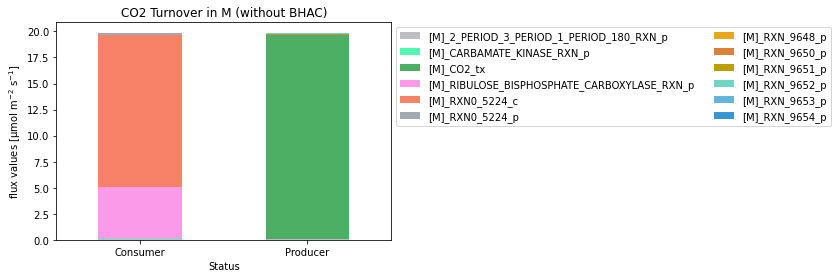

In [127]:
"""
Plot the pivot table and barplot
"""

#plt.style.use('dark_background')

chart = all_reactions.pivot_table(index="Status", columns="label", values="new_flux")
chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "flux values [\u03BCmol m$^{-2}$ s$^{-1}$]", color = color_dict)
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
plt.title("CO2 Turnover in M (without BHAC)")
figsize = [11, 11] #To prevent the cropping of the image
#plt.savefig('RedFed_NbyM_M.jpeg', format='jpeg', bbox_inches = 'tight')
plt.savefig('figures/C4/CO2-M_BHAC-no.png', format='jpeg', bbox_inches = 'tight', dpi=300)
chart



In [128]:
c4_model.reactions.get_by_id('[M]_GLY3KIN_RXN_p')

Reaction identifier,[M]_GLY3KIN_RXN_p
Name,GLY3KIN-RXN:Glycerate kinase
Memory address,0x02a9effbd308
Stoichiometry,[M]_ATP_p + [M]_GLYCERATE_p --> [M]_ADP_p + [M]_G3P_p + 0.9 [M]_PROTON_p C10H12N5O13P3 + C3H5O4 --> C10H12N5O10P2 + C3H4O7P1 + 0.9 H1
GPR,
Lower bound,0.0
Upper bound,1000.0
